In [1]:
import pandas as pd
import numpy as np
import joblib
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedShuffleSplit, train_test_split, cross_val_score, cross_val_predict

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
# Source: https://www.kaggle.com/shivam271882/news-classification-dataset
df = pd.read_csv('dataset/news.csv')
df

,category,text,cleaned_text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,there be Mass shooting in Texas last Week but ...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Will Smith Joins Diplo and Nicky Jam for the W...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,Hugh Grant marrie for the first Time at Age au...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Jim Carrey Blasts Castrato Adam Schiff and Dem...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Julianna Margulies use Donald Trump Poop bag t...
...,...,...,...
200797,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,RIM CEO Thorsten Heins significant plan for Bl...
200798,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,Maria Sharapova Stunned by Victoria Azarenka i...
200799,SPORTS,Giants Over Patriots Jets Over Colts Among Mo...,Giants over patriot jet over Colts among Most ...
200800,SPORTS,Aldon Smith Arrested,Aldon Smith Arrested


In [3]:
# Concatenate headline and article text
df["text"] = df["headline"].map(str) + ' ' + df["short_description"]

# Drop unnecessary columns
df.drop(['headline', 'short_description','authors'], axis=1, inplace=True)

In [4]:
df

,category,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Wee...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The ...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age ...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And ...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bag...
...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans F...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka ...
200850,SPORTS,Giants Over Patriots Jets Over Colts Among M...
200851,SPORTS,Aldon Smith Arrested //www.huffingtonpost.com...


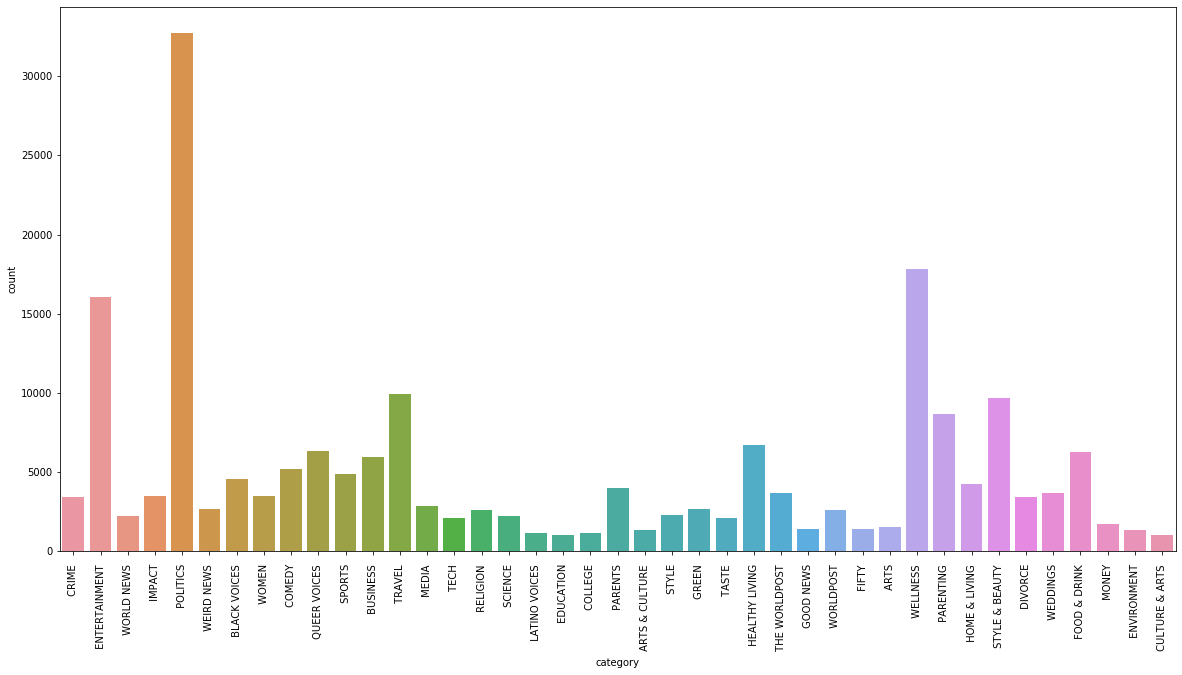

In [6]:
plt.figure(figsize=(20,10))
category_counts = sns.countplot(df.category) 
category_counts.set_xticklabels(category_counts.get_xticklabels(), rotation=90);

### Clean and normalize text for tokenization

In [ ]:
def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
        
    apostrophe_handled = re.sub("’", "'", decoded)
    parsed = nlp(apostrophe_handled)
    
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
                    
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected


df['cleaned_text'] = [spacy_cleaner(t) for t in df['text']]

## Initial metrics

In [77]:
y = df['category'].values
classifications = df.category.unique()
classifications.sort()

In [4]:
count_vectorizer = CountVectorizer(
    ngram_range=(1,2),
    stop_words='english',
    max_df=0.75, # ignores terms that appear in more than 75% of the documents
    min_df=10 # ignores terms that appear in less than than 10 documents
)
counts = count_vectorizer.fit_transform(df['cleaned_text'].values)

X_train, X_test, y_train, y_test = train_test_split(counts, y, stratify=y)
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=classifications))

                precision    recall  f1-score   support

          ARTS       0.45      0.16      0.24       377
ARTS & CULTURE       0.44      0.10      0.17       334
  BLACK VOICES       0.52      0.40      0.45      1132
      BUSINESS       0.45      0.48      0.46      1483
       COLLEGE       0.46      0.17      0.25       286
        COMEDY       0.54      0.43      0.48      1293
         CRIME       0.46      0.66      0.54       851
CULTURE & ARTS       0.79      0.19      0.31       257
       DIVORCE       0.77      0.62      0.69       857
     EDUCATION       0.50      0.22      0.30       251
 ENTERTAINMENT       0.57      0.71      0.63      4014
   ENVIRONMENT       0.71      0.18      0.29       330
         FIFTY       0.54      0.06      0.10       350
  FOOD & DRINK       0.55      0.75      0.64      1556
     GOOD NEWS       0.51      0.09      0.15       349
         GREEN       0.43      0.41      0.42       656
HEALTHY LIVING       0.38      0.16      0.23  

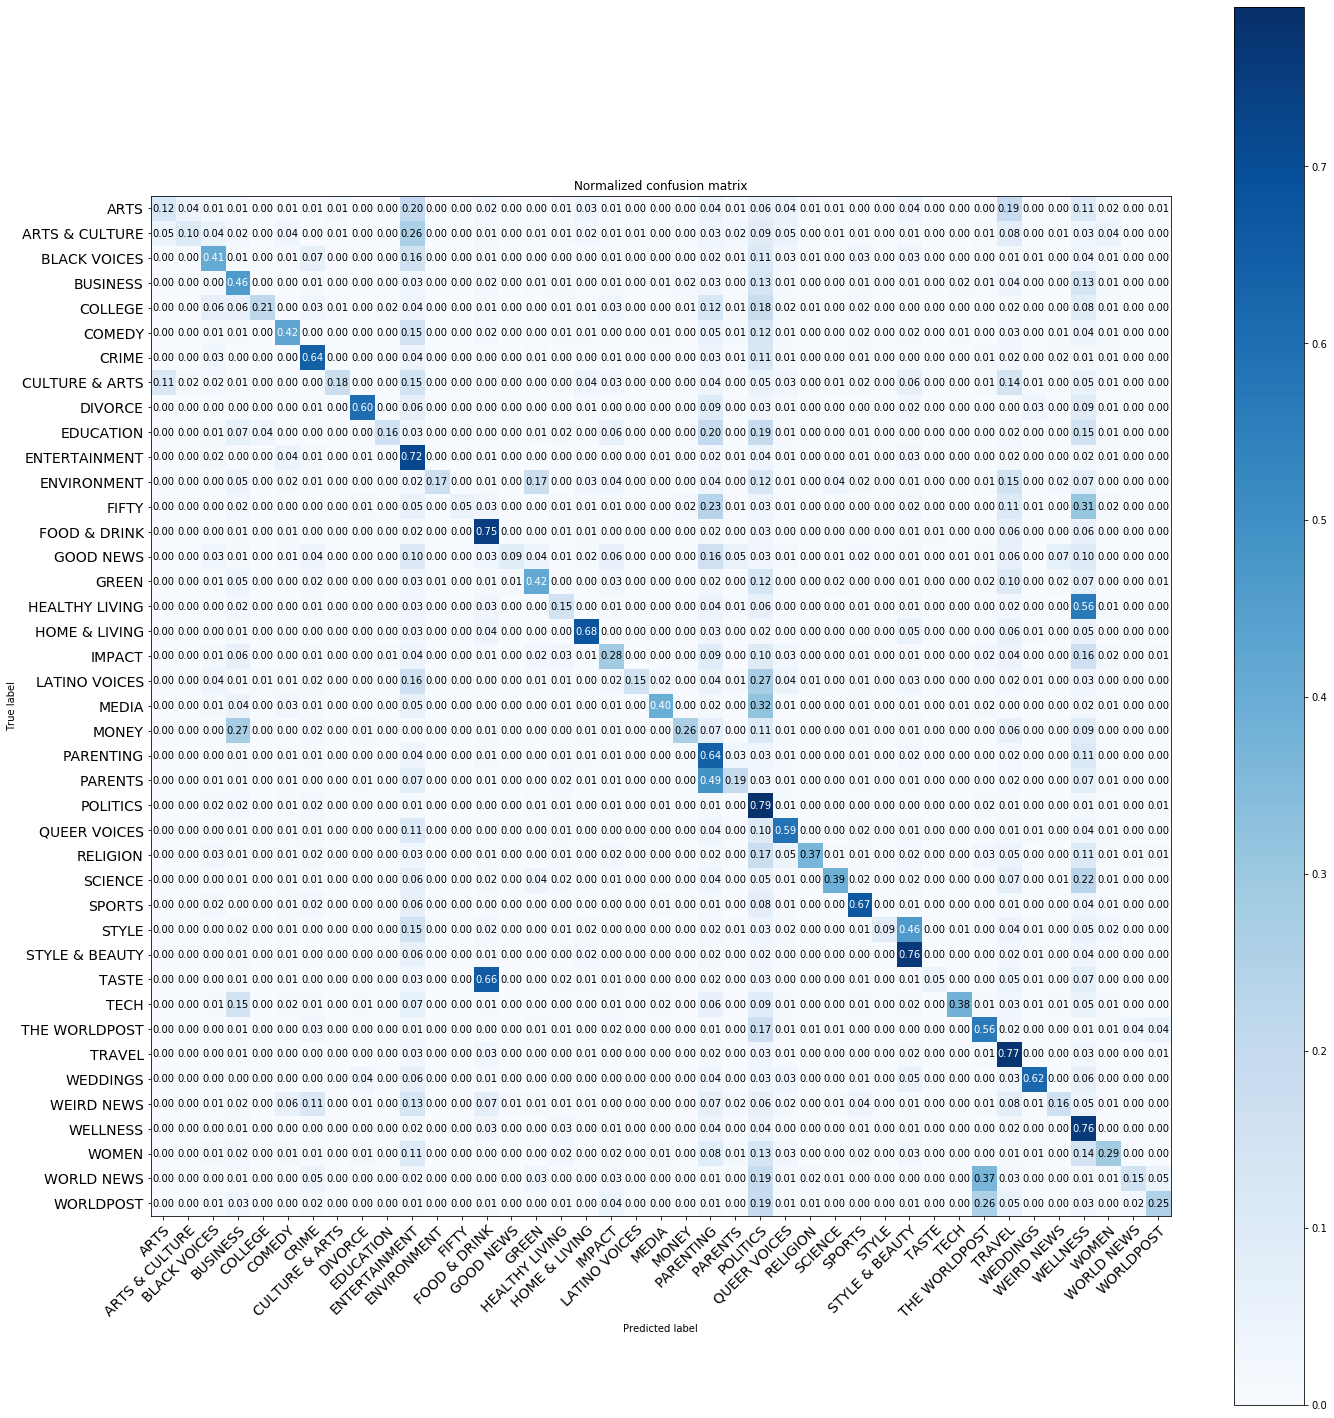

In [7]:
X_train, X_test, y_train, y_test = train_test_split(counts, y, stratify=y)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=classifications, normalize=True);

In [11]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    stop_words='english',
    max_df=0.75, # ignores terms that appear in more than 75% of the documents
    min_df=10 # ignores terms that appear in less than than 5 documents
)
tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'].values)

X_train, X_test, y_train, y_test = train_test_split(tfidf, y, stratify=y)
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=classifications))

                precision    recall  f1-score   support

          ARTS       0.62      0.04      0.07       377
ARTS & CULTURE       0.00      0.00      0.00       334
  BLACK VOICES       0.69      0.09      0.15      1132
      BUSINESS       0.64      0.16      0.26      1483
       COLLEGE       0.00      0.00      0.00       286
        COMEDY       0.77      0.12      0.21      1293
         CRIME       0.68      0.26      0.38       851
CULTURE & ARTS       1.00      0.11      0.20       257
       DIVORCE       0.93      0.32      0.48       857
     EDUCATION       0.80      0.02      0.03       251
 ENTERTAINMENT       0.44      0.80      0.57      4014
   ENVIRONMENT       0.96      0.08      0.15       330
         FIFTY       0.00      0.00      0.00       350
  FOOD & DRINK       0.64      0.59      0.61      1556
     GOOD NEWS       0.00      0.00      0.00       349
         GREEN       0.78      0.05      0.09       656
HEALTHY LIVING       0.75      0.02      0.05  

### TFIDF shows issues with imbalanced data, particularly the Politics class

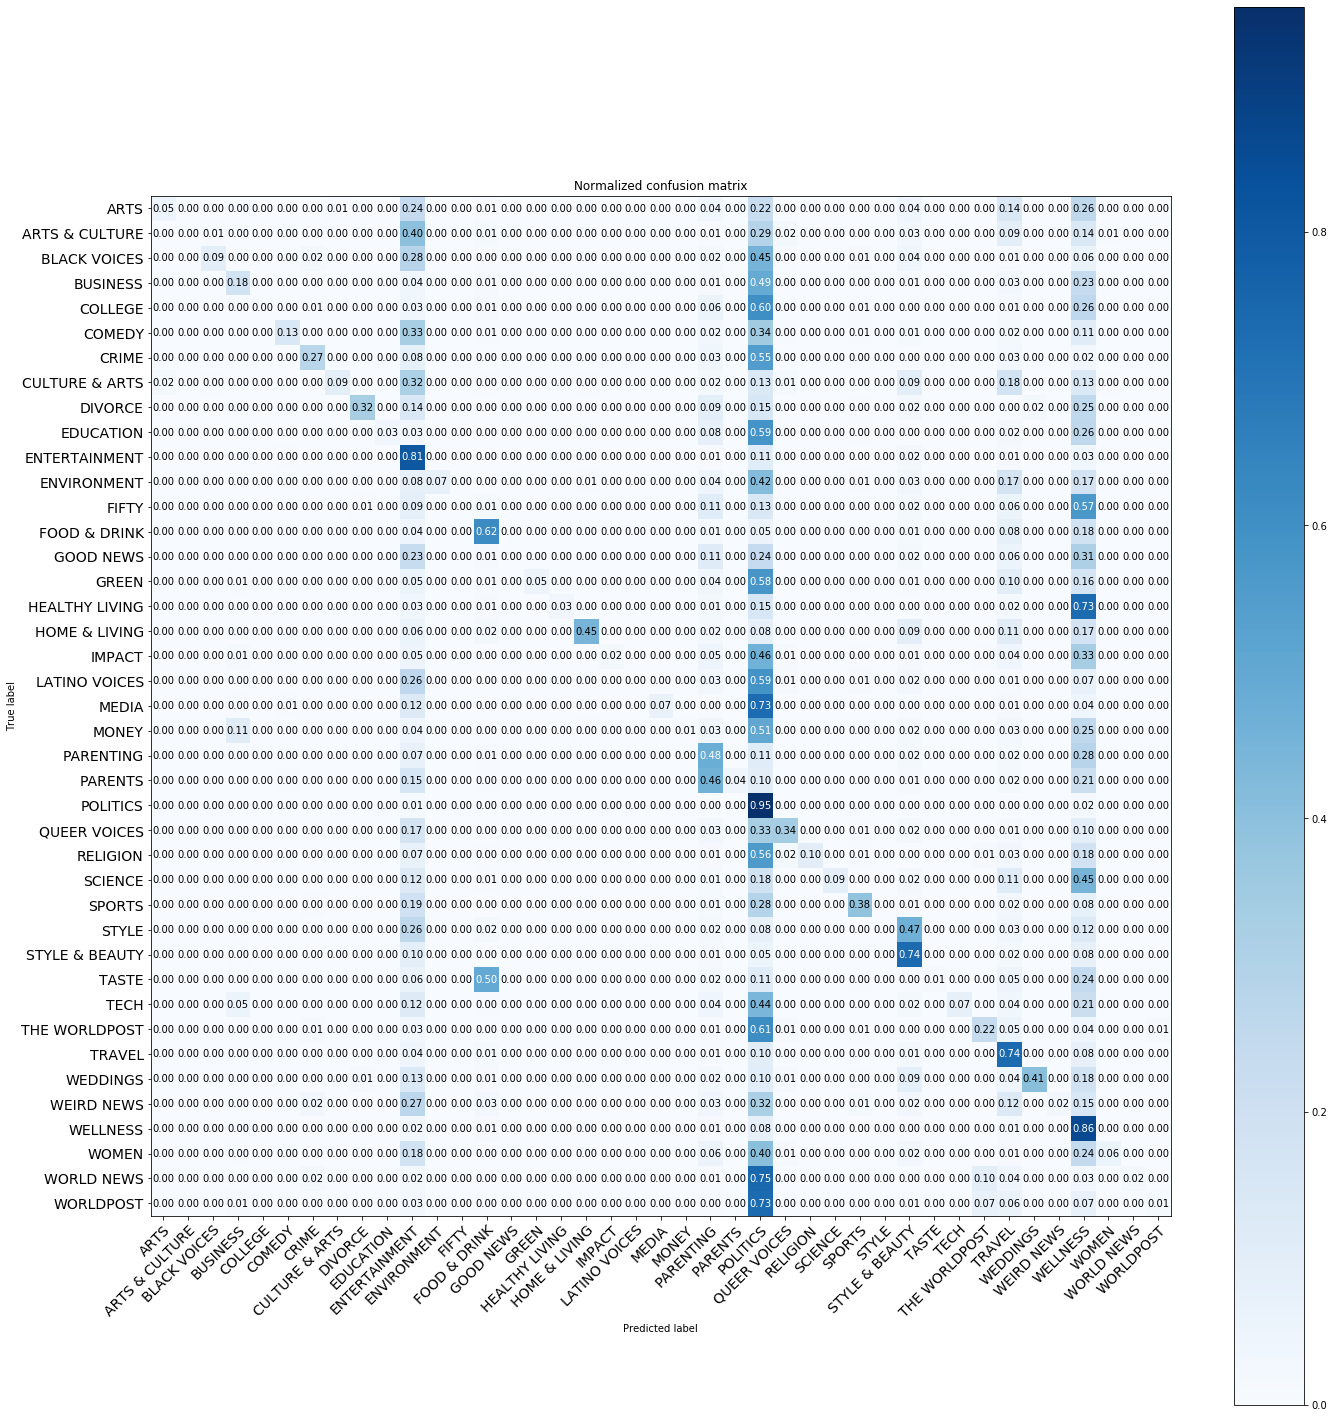

In [12]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, stratify=y)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=classifications, normalize=True);

### Merge similar classes

In [13]:
df['category'] = df['category'].str.replace('CULTURE & ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].str.replace('THE WORLDPOST', 'WORLD NEWS')
df['category'] = df['category'].str.replace('WORLDPOST', 'WORLD NEWS')
df['category'] = df['category'].str.replace('MONEY', 'BUSINESS')
df['category'] = df['category'].str.replace('^ARTS$', 'ARTS & CULTURE', regex=True)
df['category'] = df['category'].str.replace('PARENTS', 'PARENTING')
df['category'] = df['category'].str.replace('STYLE & BEAUTY', 'STYLE')
df['category'] = df['category'].str.replace('TASTE', 'FOOD & DRINK')
df['category'] = df['category'].str.replace('HEALTHY LIVING', 'WELLNESS')
df['category'] = df['category'].str.replace('GREEN', 'ENVIRONMENT')

y = df['category'].values
classifications = df.category.unique()
classifications.sort()

In [80]:
count_vectorizer = CountVectorizer(
    ngram_range=(1,2),
    stop_words='english',
    max_df=0.75, # ignores terms that appear in more than 75% of the documents
    min_df=10 # ignores terms that appear in less than than 10 documents
)
counts = count_vectorizer.fit_transform(df['cleaned_text'].values)

X_train, X_test, y_train, y_test = train_test_split(counts, y, stratify=y)
count_clf = MultinomialNB()
count_clf.fit(X_train, y_train)

y_pred = count_clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=classifications))

                precision    recall  f1-score   support

ARTS & CULTURE       0.61      0.38      0.47       969
  BLACK VOICES       0.53      0.41      0.46      1132
      BUSINESS       0.53      0.54      0.54      1910
       COLLEGE       0.47      0.16      0.24       286
        COMEDY       0.55      0.43      0.48      1293
         CRIME       0.49      0.64      0.56       851
       DIVORCE       0.81      0.59      0.68       856
     EDUCATION       0.51      0.19      0.27       251
 ENTERTAINMENT       0.60      0.71      0.65      4014
   ENVIRONMENT       0.57      0.47      0.51       986
  FOOD & DRINK       0.70      0.79      0.74      2080
 HOME & LIVING       0.80      0.67      0.72      1048
 LATINO VOICES       0.70      0.12      0.21       282
         MEDIA       0.59      0.41      0.49       704
     PARENTING       0.58      0.71      0.64      3158
      POLITICS       0.72      0.77      0.74      8184
  QUEER VOICES       0.69      0.58      0.63  

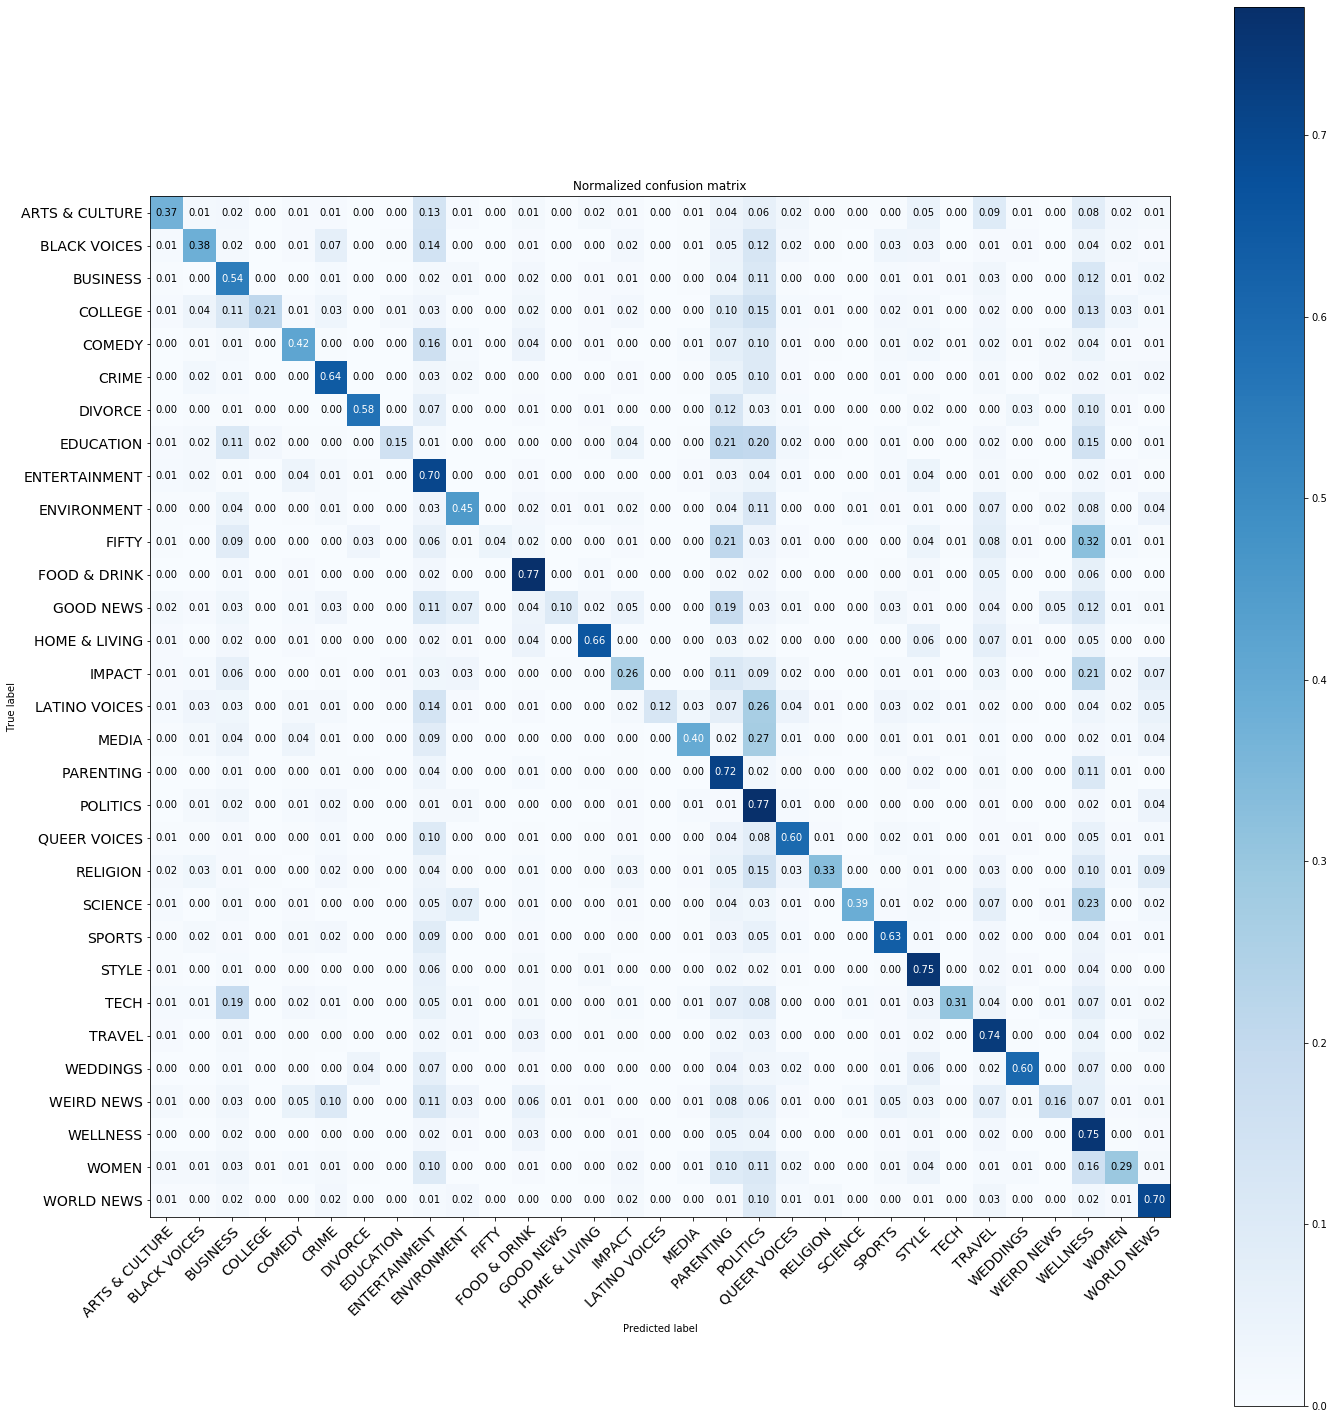

In [15]:
X_train, X_test, y_train, y_test = train_test_split(counts, y, stratify=y)

count_clf = MultinomialNB()
count_clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=classifications, normalize=True);

In [16]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    stop_words='english',
    max_df=0.75, # ignores terms that appear in more than 75% of the documents
    min_df=10 # ignores terms that appear in less than than 5 documents
)
tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'].values)

X_train, X_test, y_train, y_test = train_test_split(tfidf, y, stratify=y)
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=classifications))

                precision    recall  f1-score   support

ARTS & CULTURE       0.91      0.13      0.23       969
  BLACK VOICES       0.70      0.08      0.14      1132
      BUSINESS       0.66      0.26      0.38      1910
       COLLEGE       1.00      0.00      0.01       286
        COMEDY       0.79      0.13      0.22      1293
         CRIME       0.71      0.22      0.33       851
       DIVORCE       0.96      0.30      0.46       857
     EDUCATION       1.00      0.02      0.05       251
 ENTERTAINMENT       0.50      0.77      0.61      4014
   ENVIRONMENT       0.76      0.14      0.23       986
         FIFTY       0.00      0.00      0.00       350
  FOOD & DRINK       0.78      0.65      0.71      2080
     GOOD NEWS       0.00      0.00      0.00       349
 HOME & LIVING       0.96      0.42      0.58      1048
        IMPACT       0.44      0.00      0.01       863
 LATINO VOICES       0.00      0.00      0.00       282
         MEDIA       0.75      0.05      0.10  

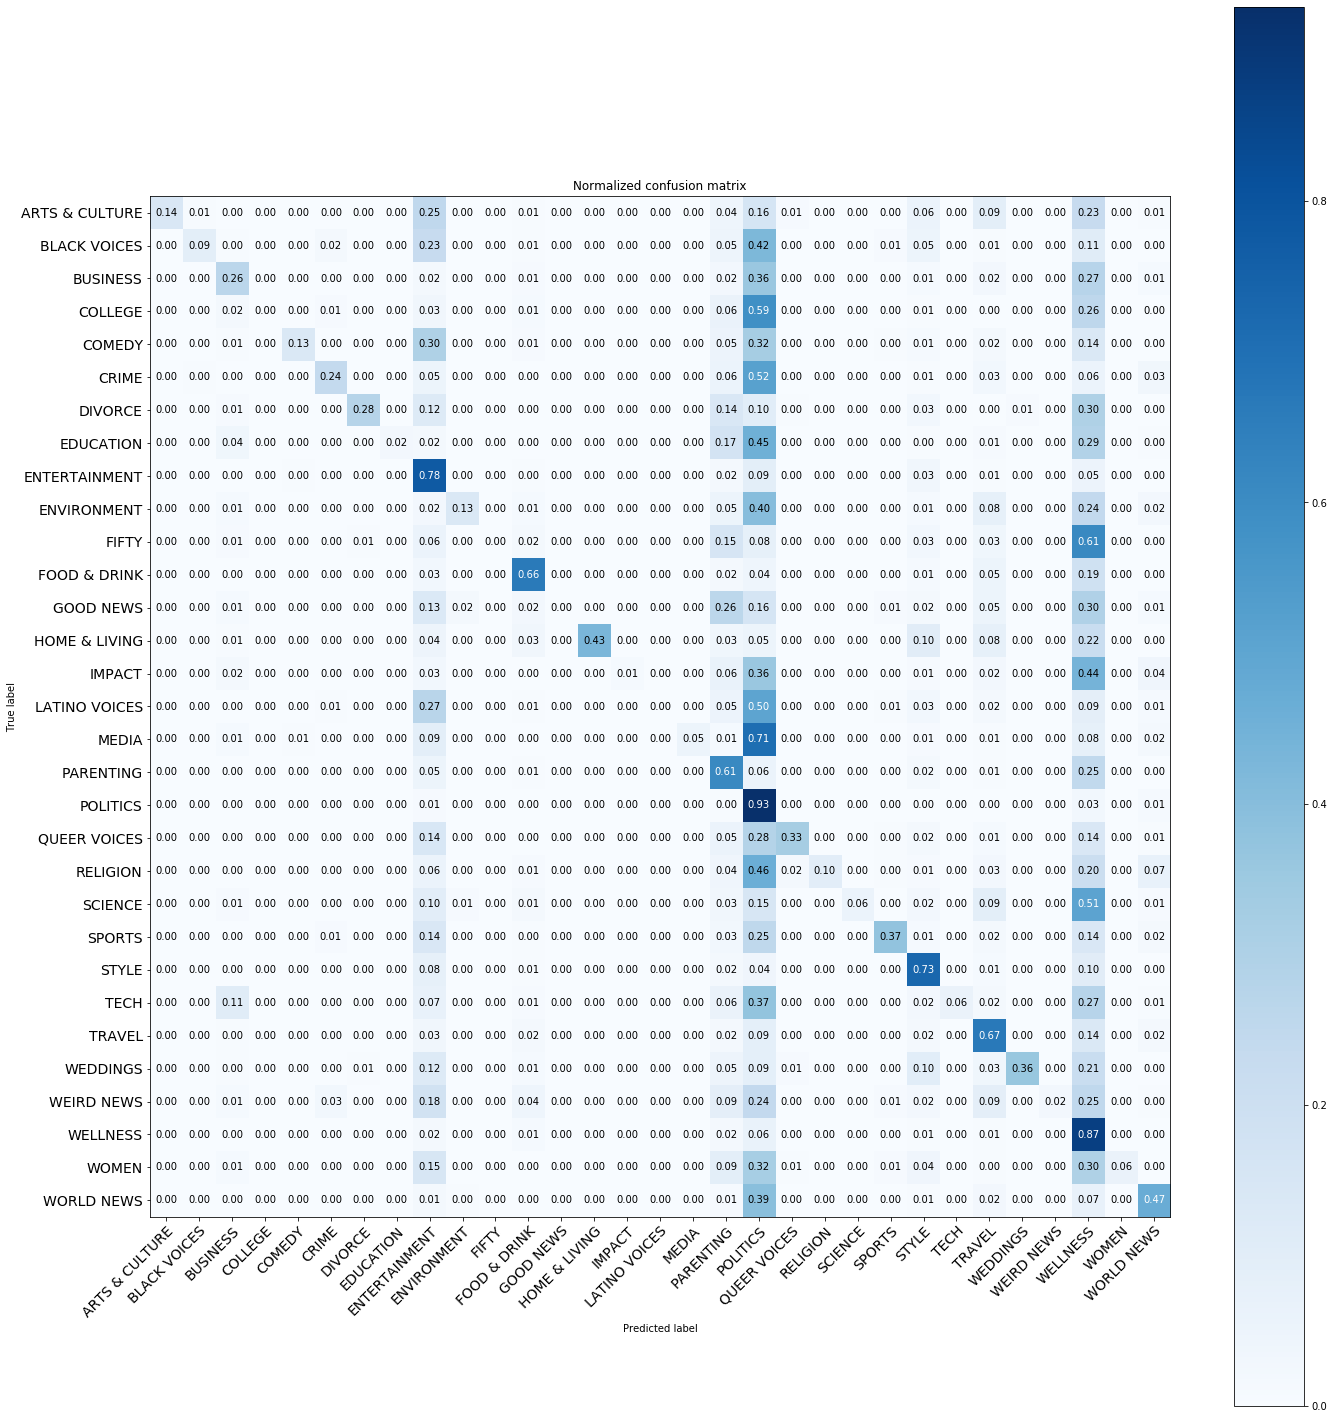

In [17]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, stratify=y)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=classifications, normalize=True);

## Oversampling with SMOTE

In [81]:
smote = SMOTE(sampling_strategy='minority')
X_sm_counts, y_sm_counts = smote.fit_sample(counts, y)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_sm_counts, y_sm_counts, stratify=y_sm_counts)
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=classifications))

                precision    recall  f1-score   support

ARTS & CULTURE       0.62      0.38      0.47       969
  BLACK VOICES       0.52      0.39      0.44      1132
      BUSINESS       0.55      0.55      0.55      1910
       COLLEGE       0.43      0.14      0.21       286
        COMEDY       0.55      0.40      0.46      1293
         CRIME       0.51      0.63      0.56       851
       DIVORCE       0.79      0.59      0.68       856
     EDUCATION       0.91      0.93      0.92      8184
 ENTERTAINMENT       0.60      0.70      0.65      4014
   ENVIRONMENT       0.59      0.51      0.55       986
  FOOD & DRINK       0.72      0.78      0.75      2080
 HOME & LIVING       0.80      0.65      0.72      1048
 LATINO VOICES       0.58      0.11      0.19       282
         MEDIA       0.57      0.41      0.48       704
     PARENTING       0.58      0.70      0.63      3158
      POLITICS       0.73      0.77      0.75      8184
  QUEER VOICES       0.69      0.58      0.63  

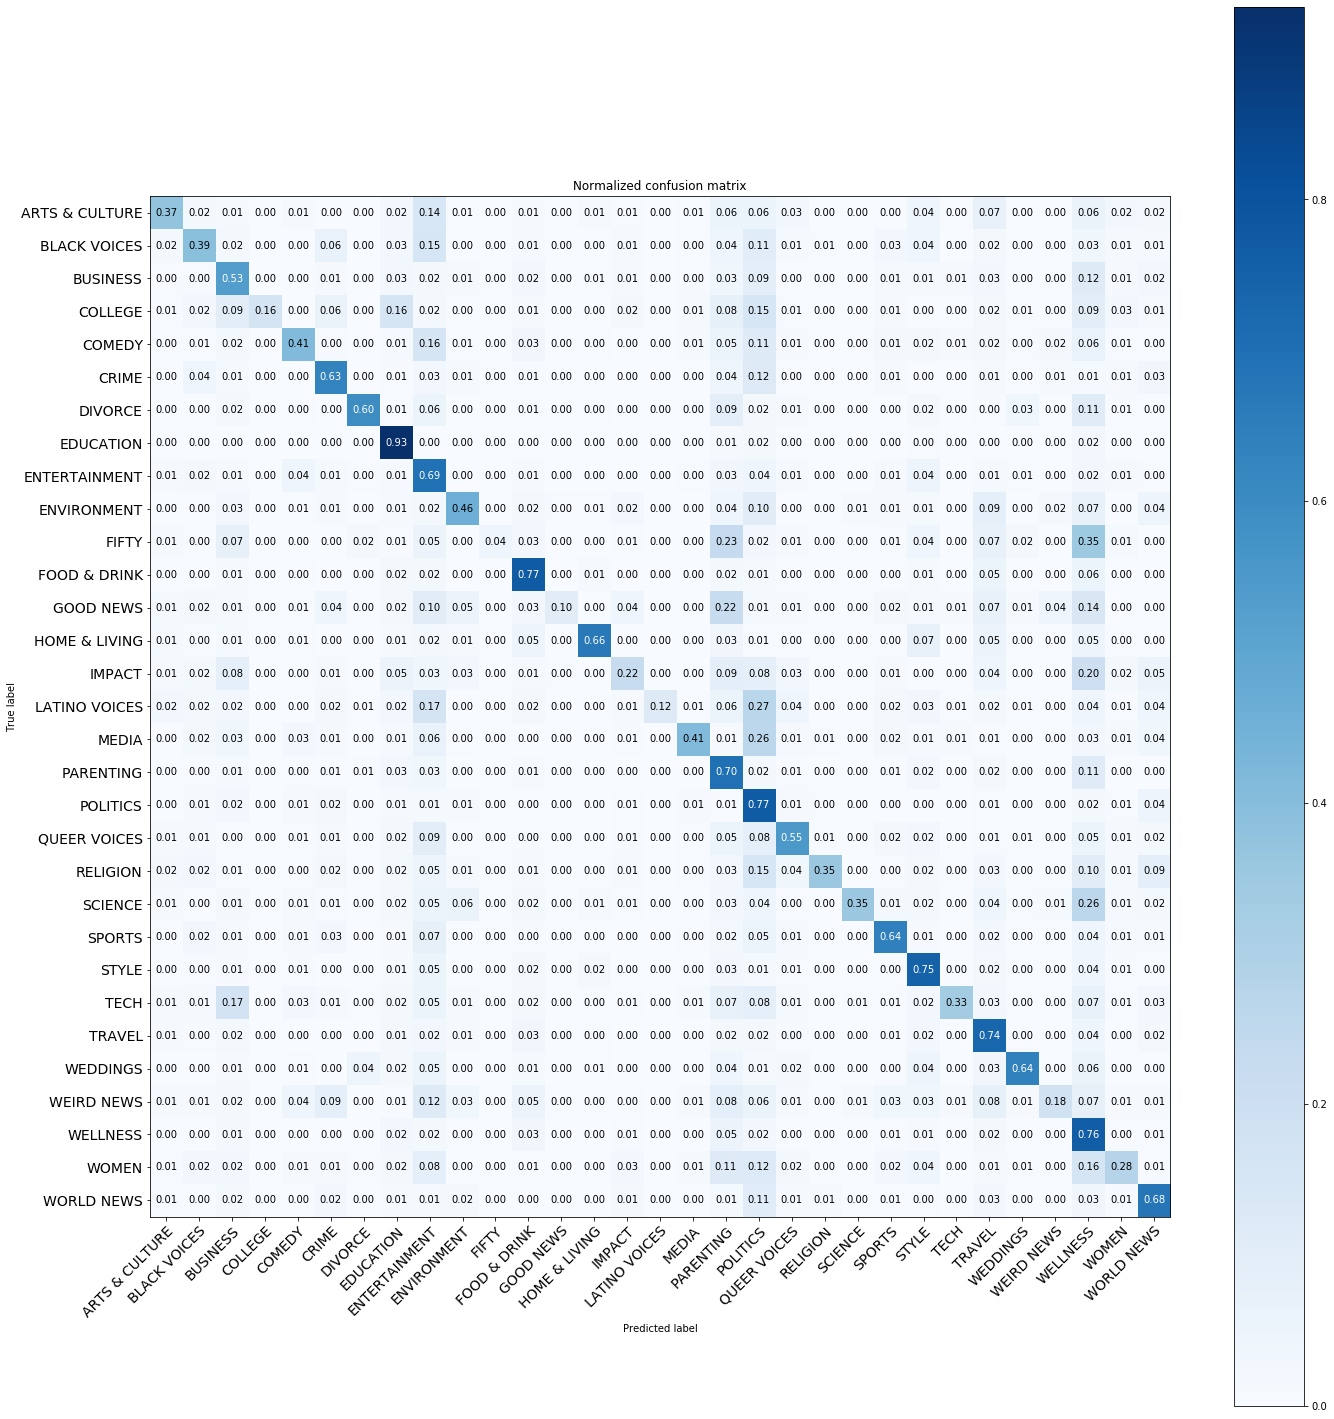

In [20]:
plot_confusion_matrix(y_test, y_pred, classes=classifications, normalize=True);

## Show top 5 associated words for each class

In [95]:
for category in set(y_sm_counts):
    features_chi2 = chi2(X_sm_counts, y_sm_counts == category)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(count_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(f'{category}')
    print(unigrams[-5:])
    print(bigrams[-5:])

RELIGION
['jesus', 'religious', 'church', 'francis', 'pope']
['catholic church', 'church author', 'people faith', 'pope francis', 'daily meditation']
ENVIRONMENT
['oil', 'huffpo', 'dog', 'animal', 'climate']
['huffpo shortdescription', 'extreme weather', 'animal photos', 'photos week', 'climate change']
CRIME
['murder', 'officer', 'allegedly', 'suspect', 'police']
['year old', 'author suspect', 'fatally shoot', 'author police', 'police say']
TRAVEL
['vacation', 'trip', 'traveler', 'hotel', 'travel']
['weekly travel', 'travel zen', 'author travel', 'travel author', 'photos author']
COLLEGE
['student', 'fraternity', 'university', 'campus', 'college']
['college president', 'sexual assault', 'college author', 'college student', 'high education']
WOMEN
['funniest', 'feminism', 'feminist', 'women', 'woman']
['twitter fail', 'fail brighten', 'funniest tweets', 'woman week', 'tweets woman']
LATINO VOICES
['puerto', 'latinas', 'latina', 'latinos', 'latino']
['america ferrera', 'puerto rico', 'a

## Test different models

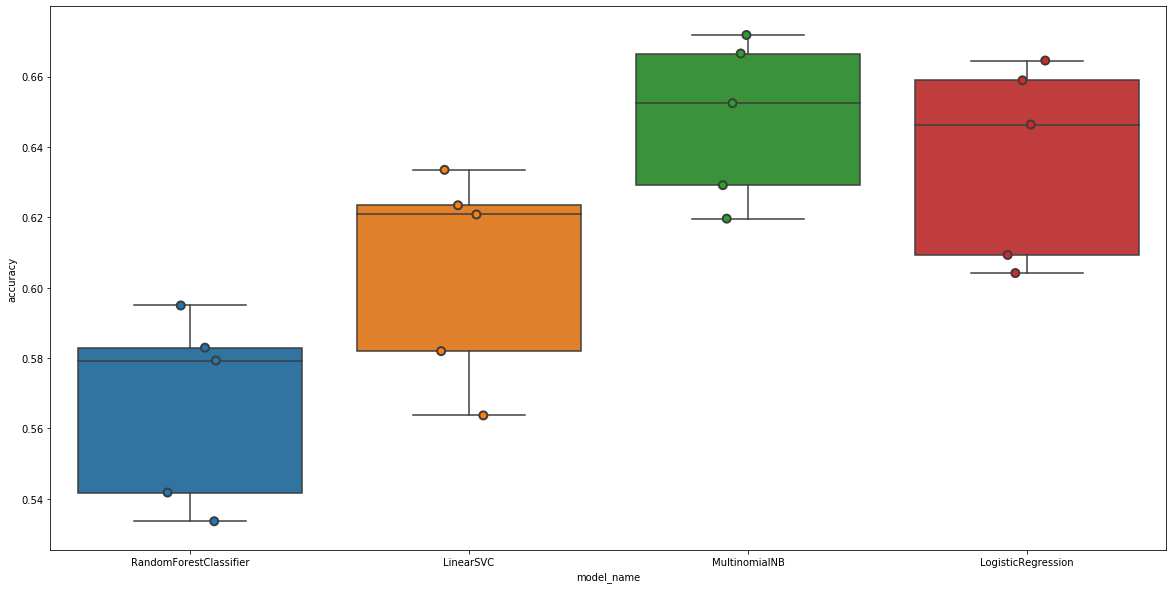

In [24]:
entries = []

models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(),
]

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(
        model, X_sm_counts, y_sm_counts, scoring='accuracy', cv=5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(20,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2);

In [25]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.604658
LogisticRegression        0.636645
MultinomialNB             0.647904
RandomForestClassifier    0.566492
Name: accuracy, dtype: float64

### Classify news article snippets

In [85]:
facial_recognition = '''\
At least for now, controversial facial-recognition technology won’t be
installed at boarding gates at Seattle-Tacoma International Airport, making the
airport the first in the country to resist the rollout of a federal biometric
identification program. After hours of impassioned public comment Tuesday, much
of it from people calling facial recognition intrusive and dangerous, the
Port of Seattle Commission unanimously approved a moratorium on some uses of
the technology.\
'''

riviera = '''\
With its romantic coastline, inviting beaches and reliable sunshine, southern
France’s Riviera region has been a tourist destination since the 1860s. A
hundred years ago, aristocrats from London to Moscow flocked here to
socialize, gamble and escape the dreary weather at home. But the area also
attracted a who’s who of 20th-century artists, who were drawn by the
Mediterranean’s bohemian atmosphere, luminous light and contrasting colors
of sea, sand and sky.\
'''

jumanji = '''\
It’s called “Jumanji,” but a better name for the game in the movie’s title
would be “Who the Heck Is Who Here?”

For starters, that sure looks like Dwayne “The Rock” Johnson, all muscly,
tatted-up and bald. Except, when he opens his mouth he sounds like Danny
DeVito, all cranky and kvetching with a pronounced Jersey accent.\
'''

articles = {
    'facial_recognition': facial_recognition, 'riviera': riviera, 'jumanji': jumanji
}

In [94]:
for article in articles:
    
    word_counts = count_vectorizer.transform([articles[article]])
    prediction = count_clf.predict_log_proba(word_counts)

    ordered_classifications = dict(zip(classifications, prediction[0]))
    ordered_classifications = {k: v for k, v in sorted(
        ordered_classifications.items(), key=lambda x: x[1], reverse=True)}

    classes = list(ordered_classifications.keys())
    scores = list(ordered_classifications.values())
        
    first_classes = classes[:5]
    last_classes = classes[-5:]
    first_prob = scores[:5]
    last_prob = scores[-5:]
    
    print()
    print(articles[article])
    print('-' * 80)
    
    print('--Top 5--')
    for i in range(5):
        print(f'{first_classes[i].lower():15s} {first_prob[i]:.2f}')
        
    print('\n--Bottom 5--')
    for i in range(5):
        print(f'{last_classes[i].lower():15s} {last_prob[i]:.2f}')
    print()  


At least for now, controversial facial-recognition technology won’t be
installed at boarding gates at Seattle-Tacoma International Airport, making the
airport the first in the country to resist the rollout of a federal biometric
identification program. After hours of impassioned public comment Tuesday, much
of it from people calling facial recognition intrusive and dangerous, the
Port of Seattle Commission unanimously approved a moratorium on some uses of
the technology.
--------------------------------------------------------------------------------
--Top 5--
business        -0.03
travel          -4.36
education       -4.79
politics        -5.54
world news      -6.40

--Bottom 5--
parenting       -31.37
food & drink    -31.53
divorce         -32.38
comedy          -32.47
style           -33.00


With its romantic coastline, inviting beaches and reliable sunshine, southern
France’s Riviera region has been a tourist destination since the 1860s. A
hundred years ago, aristocrats from Lon

### Confusion matrix function

In [96]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    fig.tight_layout()
    return ax